# Summary

This notebook solves for evolution from a composite b.c. comprising (1) initial profile surface; (2) initial corner (transition between surface and fault); (3) velocity (fault slip).

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['Composite_tanbeta_ramp_concaveup_eta1p0_xiv10_kh1p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, Eq, Matrix
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
from gme.ode_knickpoints import CompositeSolution
from gme.plot import TimeDependentPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme

# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Knickpoints')
pr_path, pr_filenames

Fetching working path from environment variable GME_WORKING_PATH = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Knickpoints',
 ['Composite_tanbeta_rampflat_concaveup_eta1p0_xiv30_xh0p9_kh1p5'])

In [2]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'CompositeSolutions',
    'short_name': 'cs',
    'subtitle': '',
    'title': 'Composite solution: ramp-flat, concave-up, fast',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'tan',
    'chi': 30,
    'do_geodesic': False,
    'eta': 1,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    't_xiv0_list': None,
    'varphi_0': 10,
    'varphi_type': 'ramp-flat',
    'x_1': 1,
    'x_h': 0.9,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': True,
    'do_ip': True,
    'do_vb': True,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'Radau', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.04,
    't_slip_end': 0.03,
    'vb_res': 301}
{   'do_eliminate_caustics': True,
    'n_isochrones': 200,
    'spline_order': 3,
    't_isochrone_max': None,
    't_isochrone_max_fraction': 1,
    'tolerance': 1e

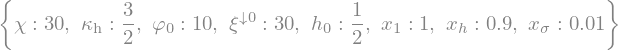

In [3]:
sub = {x_1: pr.model.x_1, 
       chi: pr.model.chi, 
       varphi_0: pr.model.varphi_0,
       xiv_0: pr.model.xiv_0,
       kappa_h: pr.model.kappa_h,
       h_0: pr.model.h_0,
       x_sigma: pr.model.x_sigma,
       x_h: pr.model.x_h}
sub

# Equations

Generate the GME equation set using Sympy, after specifying in the erosion model the gradient exponent $\eta$, the process transition model ("ramp" or "rampflat"), and the shape of the initial profile ("concave" or "convex"; not used here).

Only $\eta=1$ works for now.

In [4]:
gmeq = Equations( eta=pr.model.eta, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type,
                  ibc_type=pr.model.ibc_type )

# Integration

Integrate Hamilton's equations from an initial profile. Various ODE integration methods can be used here, but Radau quadrature turns out to be the most accurate. SciPy's "LSODA" (Adams/BDF method with automatic stiffness detection and switching) fails.

Create an instance of the ODE solution object.

In [5]:
do_solns   = dict(ip=pr.solve.do_ip,  ic=pr.solve.do_ic,  vb=pr.solve.do_vb)
resolution = dict(ip=pr.solve.ip_res, ic=pr.solve.ic_res, vb=pr.solve.vb_res)

gmes = CompositeSolution( gmeq, parameters=sub,
                          choice=pr.solve.choice, 
                          method=pr.solve.method[pr.solve.choice] )
gmes.create_solutions( do_solns=do_solns, n_rays=resolution,
                       t_end=pr.solve.t_end, t_slip_end=pr.solve.t_slip_end )

Solve Hamilton's ODEs using Radau method of integration
Solve Hamilton's ODEs using Radau method of integration
Solve Hamilton's ODEs using Radau method of integration
Solve Hamilton's ODEs using Radau method of integration


Specify the set of ODEs and integrate them.

In [6]:
gmes.solve()

0% Initial conditions 0: [0.0, 0.0, 0.0031902424177791136, -0.02130629968628595]
Initial conditions 1: [0.01, 0.0015178174577489976, 0.003222950464157981, -0.0209489745323715]
1% Initial conditions 2: [0.02, 0.003077285960044057, 0.003256277052583692, -0.02060115489525209]
2% Initial conditions 3: [0.03, 0.004679412760796035, 0.003290238486438832, -0.020262636812541018]
3% Initial conditions 4: [0.04, 0.0063252215285643735, 0.0033248516900059102, -0.019933222943924984]
4% Initial conditions 5: [0.05, 0.008015752125861864, 0.0033601342480690426, -0.019612722494732015]
5% Initial conditions 6: [0.06, 0.009752060350396318, 0.0033961044491359837, -0.019300951148478518]
6% Initial conditions 7: [0.07, 0.011535217636171621, 0.0034327813326385627, -0.01899773100867118]
7% Initial conditions 8: [0.08, 0.013366310712323994, 0.0034701847405032783, -0.018702890550171172]
8% Initial conditions 9: [0.09, 0.01524644121752429, 0.0035083353735204377, -0.018416264580462874]
9% Initial conditions 10: [0

Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [7]:
gmes.merge_rays()

In [8]:
gmes.postprocessing()

In [9]:
gmes.resolve_isochrones( t_isochrone_max=gmes.t_ensemble_max*pr.resolve.t_isochrone_max_fraction, 
                         tolerance=pr.resolve.tolerance, n_isochrones=pr.resolve.n_isochrones,
                         do_eliminate_caustics=pr.resolve.do_eliminate_caustics, dont_crop_cusps=True )

In [10]:
gmes.drpdt_lambda = gmes.ips.model_dXdt_lambda
gmes.measure_cusp_propagation()

# Plots

In [11]:
gr = TimeDependentPlots()

In [12]:
prefix = ('_').join([pr.job.short_name, 
                     gmeq.beta_type+'beta', gmeq.varphi_type.replace('-',''),
                     gmeq.ibc_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' 
                  else suffix+'_xh{:1.1f}'.format(gmes.parameters[x_h])).replace('.','p')
suffix = suffix+'_kh{:1.1f}'.format(float(gmes.parameters[kappa_h])).replace('.','p')

job_name = prefix+suffix
job_name

'cs_tanbeta_rampflat_concaveup_eta1p0_xiv30_xh0p9_kh1p5'

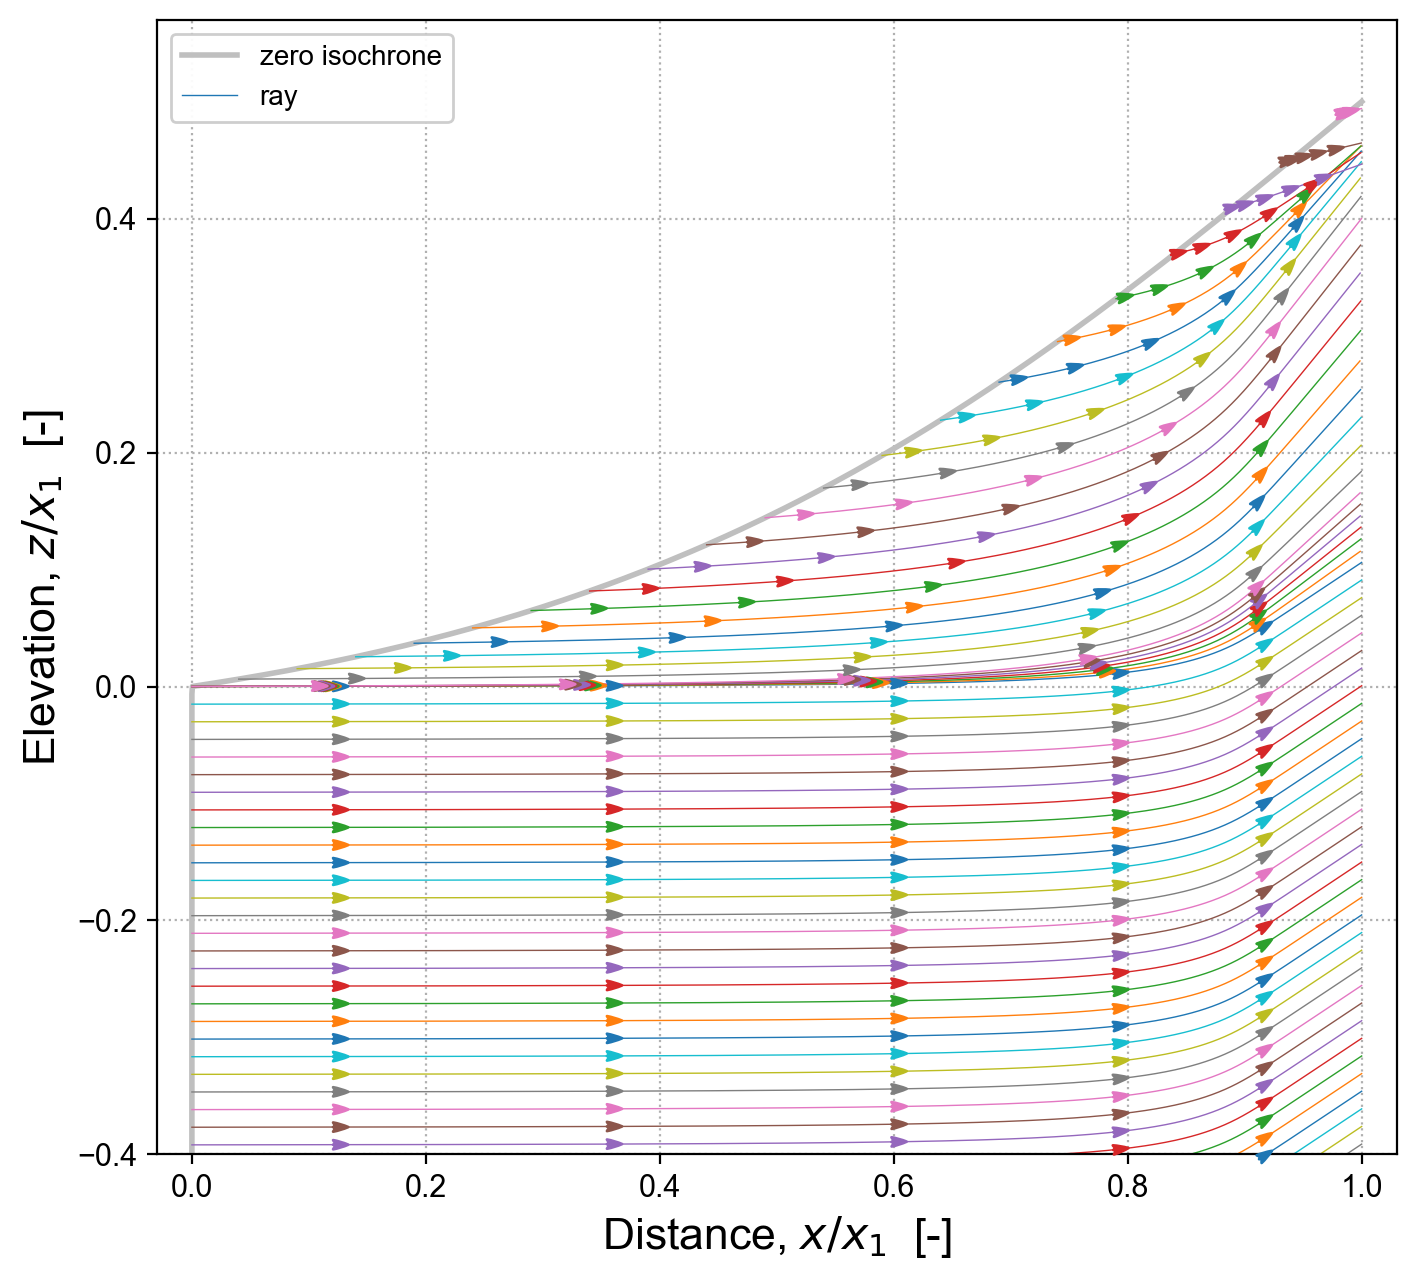

In [13]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_rays', fig_size=(8,8), 
                       do_zero_isochrone=True, do_rays=True, do_isochrones=False,
                       ray_subsetting=pr.plot.ray_subsetting,
                       do_annotate_rays=True, n_arrows=6, arrow_sf=0.5,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits );

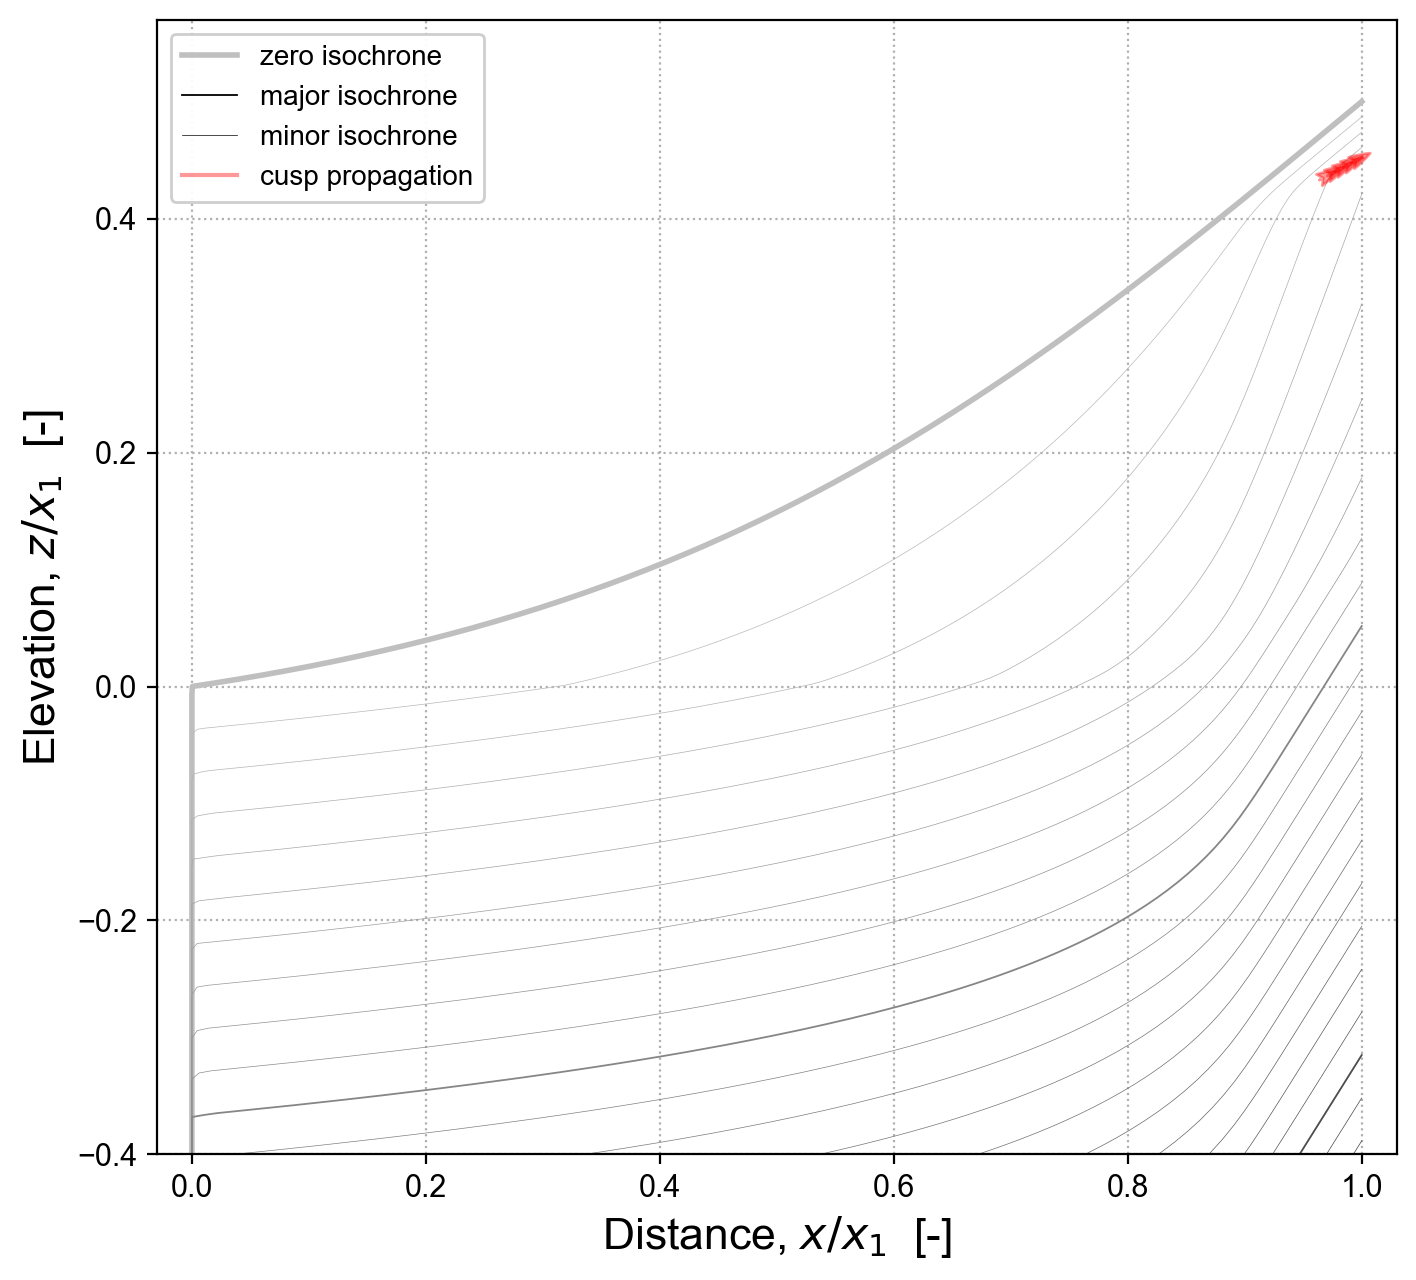

In [14]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_isochrones', fig_size=(8,8), 
                       do_zero_isochrone=True, do_rays=False, 
                       ray_subsetting=pr.plot.ray_subsetting,
                       do_isochrones=True, do_annotate_cusps=True, n_arrows=5,
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits,
                       do_legend=True, do_alt_legend=False,
                       do_infer_initiation=False );

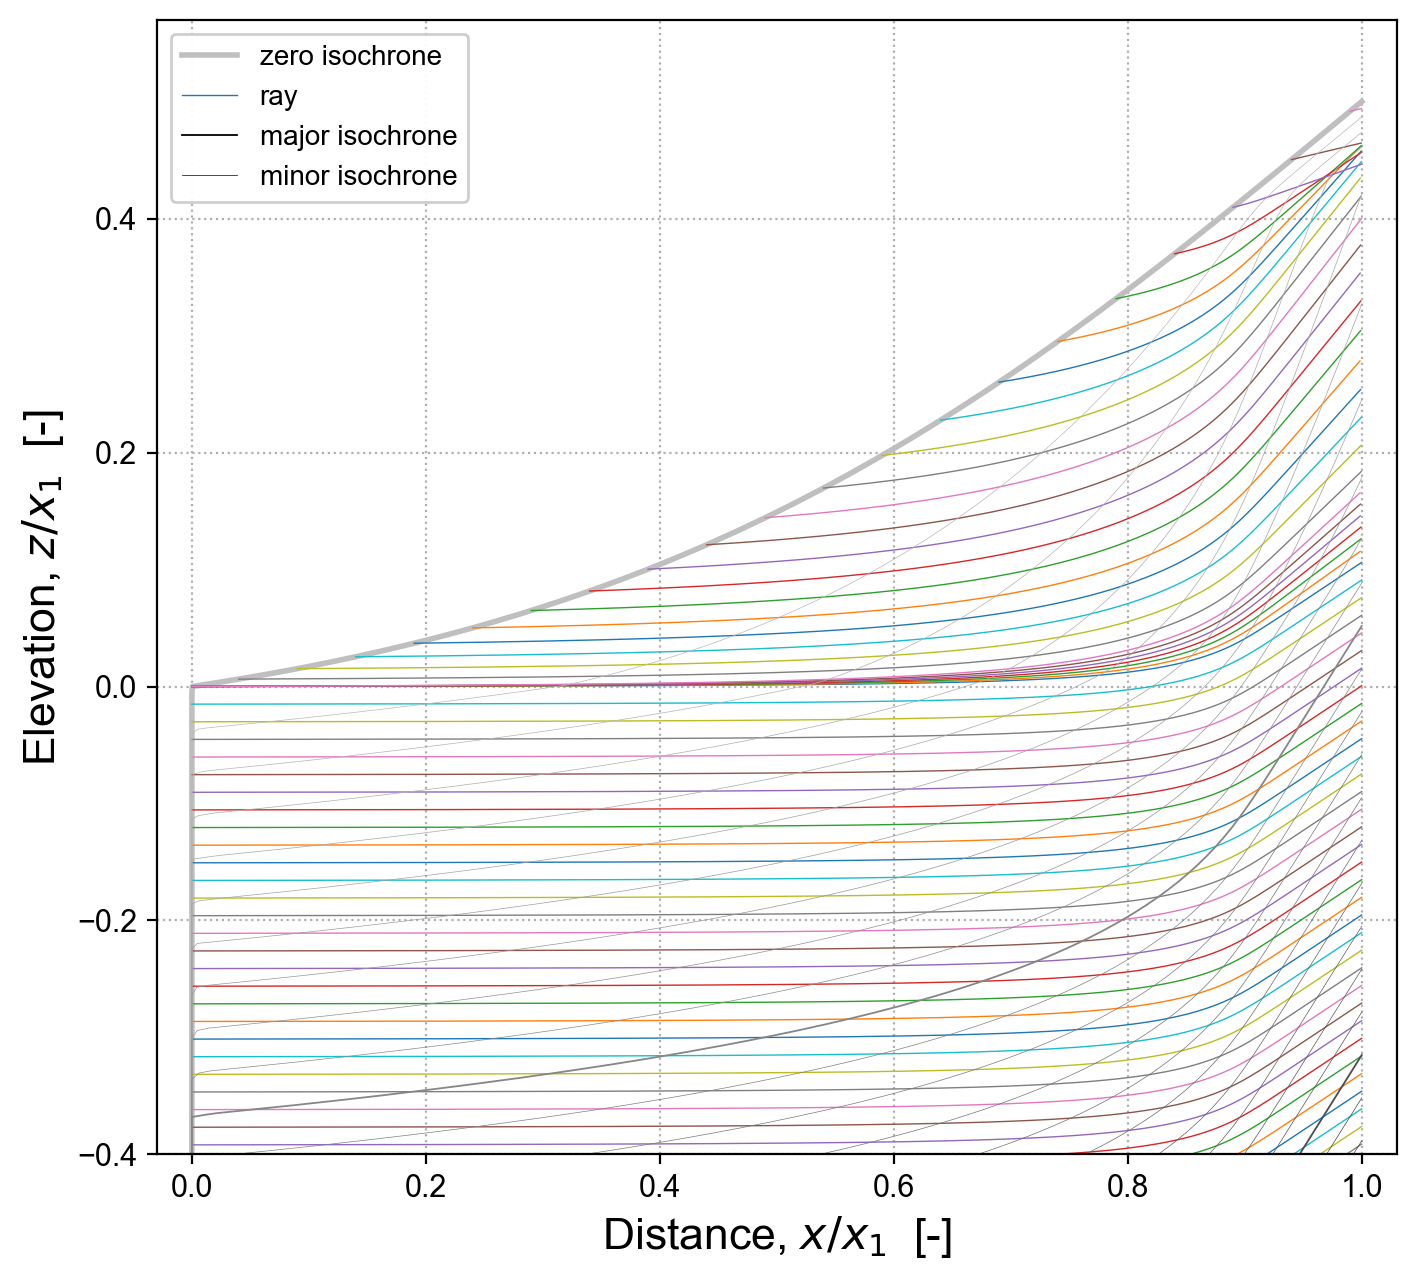

In [15]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_isochrones_rays', fig_size=(8,8), 
                       do_zero_isochrone=True,do_rays=True,do_isochrones=True,do_annotate_cusps=False,
                       ray_subsetting=pr.plot.ray_subsetting,
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits );

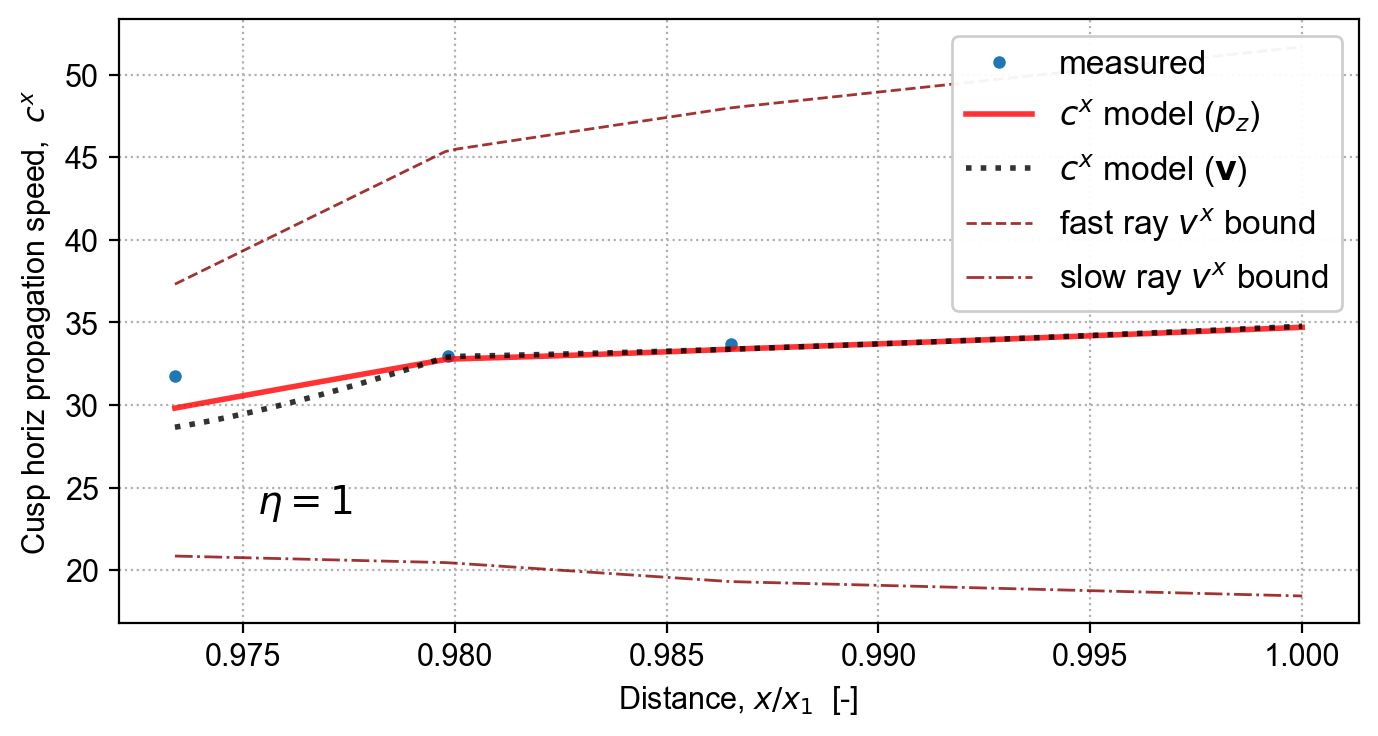

In [16]:
if gmes.cx_pz_lambda is not None:
    gr.profile_cusp_speed( gmes, gmeq, sub, job_name+'_cusp_speed', fig_size=(8,4), 
                           sample_spacing=5, x_limits=[None,None], y_limits=[None,None],
                           do_infer_initiation=False )

# Save

In [17]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/CompositeSolutions"
Exported "cs_tanbeta_rampflat_concaveup_eta1p0_xiv30_xh0p9_kh1p5_h_rays.png"
Exported "cs_tanbeta_rampflat_concaveup_eta1p0_xiv30_xh0p9_kh1p5_h_isochrones.png"
Exported "cs_tanbeta_rampflat_concaveup_eta1p0_xiv30_xh0p9_kh1p5_h_isochrones_rays.png"
Exported "cs_tanbeta_rampflat_concaveup_eta1p0_xiv30_xh0p9_kh1p5_cusp_speed.png"
